# Understanding nighttime methane signals at the Amazon Tall Tower Observatory (ATTO)

### Santiago Botía B et al
#### Calculations and analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import pandas as pd
import seaborn as sns
import scipy
import matplotlib as mpl
%matplotlib inline

In [2]:
# Remember to always import this dataframe. I dont need the one merged with micromet and soil data
d_clean_mod = pd.read_pickle('./to_Share/Data/ATTO_GHG_201203_201811_CO2avg')
ch4_30min   = d_clean_mod.iloc[:,10:15]
ch4_30min   = ch4_30min.assign(LTRound=ch4_30min.index.round('30min'))
ch4_30min.set_index('LTRound',inplace=True)
ch4_30min.head()

,CH4_79,CH4_53,CH4_38,CH4_24,CH4_4
LTRound,,,,,
2012-03-06 20:30:00,1839.65,1840.56,1841.10,1841.07,1841.22
2012-03-06 21:00:00,1839.05,1839.98,1840.43,1841.53,1842.18
2012-03-06 21:30:00,1839.52,1841.29,1840.31,1841.67,1842.13
2012-03-06 22:00:00,1841.13,1841.85,1840.89,1842.17,1843.04
2012-03-06 22:30:00,1841.74,1842.83,1841.99,1842.62,1843.40


## Section 3.1 Seasonal and diurnal patterns of CH4 gradients at ATTO
### Percentages related to Figure 4.
- Setting up data to get time percentages according to the threshold.
- Here I create the day and night dataframes used in Figures_Sect2.1-3.1.ipynb

In [3]:
# gradient
thresh    = 8
ch4_30min = ch4_30min.assign(grad = ch4_30min.CH4_79 - ch4_30min.CH4_4)
# dropping nan
print(ch4_30min.shape, 'with nan')
ch4_30min.dropna(inplace=True)
print(ch4_30min.shape, 'after dropping nan')
# setting threshold
ch4_30min = ch4_30min.assign(GradFlag = ch4_30min['grad']>thresh)
# Selecting hours from index and creating a column
ch4_30min = ch4_30min.assign(Hour = ch4_30min.index.hour)
#night columns from hours XXX This might not be necessary
idx       = (ch4_30min['Hour']<=5) | (ch4_30min['Hour']>=19)
ch4_30min = ch4_30min.assign(night_F = idx)
# highlighting the non threshold measurements
ch4_30min = ch4_30min.assign(range_8 = ch4_30min['grad'].between(-thresh,thresh,inclusive=True))
ch4_30min = ch4_30min.assign(low_than8 = ch4_30min['grad'] < -thresh)
#print('total data points',ch4_30min.shape)

(118079, 6) with nan
(79944, 6) after dropping nan


In [4]:
print('separating in range between -%d and %d, above %d and below -%d, we get:'%(thresh,thresh,thresh,thresh))
print(ch4_30min['range_8'].sum(),ch4_30min['GradFlag'].sum(),ch4_30min['low_than8'].sum(),ch4_30min['range_8'].sum()+ch4_30min['GradFlag'].sum()+ch4_30min['low_than8'].sum())
print('last number is to confirm the total number of data points, should always be the same')

separating in range between -8 and 8, above 8 and below -8, we get:
63442 9461 7041 79944
last number is to confirm the total number of data points, should always be the same


In [5]:
print('Adding below and above -8 and 8 we get the following. Remember I havent separated between day and night')
ch4_30min['GradFlag'].sum()+ch4_30min['low_than8'].sum()

Adding below and above -8 and 8 we get the following. Remember I havent separated between day and night


16502

In [6]:
# Separating nights and day
nights = ch4_30min.between_time('20:00','06:00')
days   = ch4_30min.between_time('06:00','18:00')

In [8]:
# Separating nights and day I finally corrected the manuscript using this partitioning
nights = ch4_30min.between_time('20:00','06:00')
days   = ch4_30min.between_time('07:00','18:00')

In [9]:
# Grouping each range per month and calculating the total nights measurements to get percentages
nights_upper = nights['GradFlag'].groupby([nights.index.year,nights.index.month]).sum()
nights_mid   = nights['range_8'].groupby([nights.index.year,nights.index.month]).sum()
nights_lower = nights['low_than8'].groupby([nights.index.year,nights.index.month]).sum()

nights_upper.index.rename(['Year','Month'],inplace=True)
nights_mid.index.rename(['Year','Month'],inplace=True)
nights_lower.index.rename(['Year','Month'],inplace=True)

total_nights = nights['GradFlag'].loc[nights['GradFlag']==True].groupby(nights[nights['GradFlag']==True].index.month).count() + nights['GradFlag'].loc[nights['GradFlag']==False].groupby(nights[nights['GradFlag']==False].index.month).count()

n_upp_month  = nights_upper.groupby(level=1).sum()/total_nights
n_mid_month  = nights_mid.groupby(level=1).sum()/total_nights
n_low_month  = nights_lower.groupby(level=1).sum()/total_nights
total_n      = n_low_month + n_mid_month + n_upp_month

In [10]:
# Grouping each range per month and calculating the total day measuremenst to get percentages
days_upper = days['GradFlag'].groupby([days.index.year,days.index.month]).sum()
days_mid   = days['range_8'].groupby([days.index.year,days.index.month]).sum()
days_lower = days['low_than8'].groupby([days.index.year,days.index.month]).sum()

days_upper.index.rename(['Year','Month'],inplace=True)
days_mid.index.rename(['Year','Month'],inplace=True)
days_lower.index.rename(['Year','Month'],inplace=True)

total_days = days['GradFlag'].loc[days['GradFlag']==True].groupby(days[days['GradFlag']==True].index.month).count() + days['GradFlag'].loc[days['GradFlag']==False].groupby(days[days['GradFlag']==False].index.month).count()

d_upp_month  = days_upper.groupby(level=1).sum()/total_days
d_mid_month  = days_mid.groupby(level=1).sum()/total_days
d_low_month  = days_lower.groupby(level=1).sum()/total_days
total_d      = d_low_month + d_mid_month + d_upp_month

In [11]:
# Merging ranges for night and day and creating a day and night dataframes that can be used to hue in seaborn.
df_n = pd.concat([n_low_month,n_mid_month,n_upp_month,total_n],axis=1)
df_n.reset_index(inplace=True)
df_n.columns = ['month','lower_than8','MidRange','UpperRange','total']

df_d = pd.concat([d_low_month,d_mid_month,d_upp_month,total_d],axis=1)
df_d.reset_index(inplace=True)
df_d.columns = ['month','lower_than8','MidRange','UpperRange','total']

df_day_night = pd.concat([df_d,df_n],axis=0)
df_day_night = df_day_night.assign(Time = ['day','day','day', 'day', 'day','day','day', 'day','day','day','day','day','night','night',
                                           'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night', 'night'])

In [93]:
print("Contribution to total time during daytime and nighttime of the classes defined above,\n daytime as 07:00 to 18:00")
print(df_d*100)
print(df_n*100)

Contribution to total time during daytime and nighttime of the classes defined above,
 daytime as 07:00 to 18:00
    month  lower_than8   MidRange  UpperRange  total
0     100     0.262985  99.013807    0.723208  100.0
1     200     0.904977  97.319875    1.775148  100.0
2     300     2.101835  96.714032    1.184133  100.0
3     400     3.972222  93.194444    2.833333  100.0
4     500     8.710801  87.617261    3.671938  100.0
5     600    18.679549  75.093935    6.226516  100.0
6     700    22.333637  67.578244   10.088119  100.0
7     800    17.603093  70.051546   12.345361  100.0
8     900     7.798742  83.773585    8.427673  100.0
9    1000     4.561541  89.461266    5.977192  100.0
10   1100     2.914447  92.478847    4.606706  100.0
11   1200     0.681508  96.910495    2.407996  100.0
    month  lower_than8   MidRange  UpperRange  total
0     100     1.582278  94.303797    4.113924  100.0
1     200     2.073306  93.002592    4.924102  100.0
2     300     3.674374  90.370605    5.

In [87]:
# changing columns names for export
df_n.columns = ['Months','lower_than_minus8','Between_minus8_plus8','greater_than8','total']
df_d.columns = ['Months','lower_than_minus8','Between_minus8_plus8','greater_than8','total']
#df_d.to_pickle('./to_Share/Data/ATTO_Month_dayTime_timefrac')
#df_n.to_pickle('./to_Share/Data/ATTO_Month_nightTime_timefrac')

In [13]:
print('Mean monthly gradient during nighttime when 8pbb threshold holds')
nights[nights['GradFlag'] == True].groupby(nights[nights['GradFlag'] == True].index.month).mean()['grad']

Mean monthly gradient during nighttime when 8pbb threshold holds


LTRound
1     15.263162
2     16.532406
3     20.289043
4     19.778522
5     21.393953
6     19.843176
7     23.541711
8     27.446447
9     32.273899
10    25.176571
11    17.333174
12    14.276000
Name: grad, dtype: float64

#### The following shows the mean minima for nighttime and daytime gradients, -236.2 and -455 for October. I refer to this value in section 3.1.

In [15]:
# Nights stats without applying threshold
nights['grad'].groupby(nights['grad'].index.month).describe()

,count,mean,std,min,25%,50%,75%,max
LTRound,,,,,,,,
1,2844.0,-0.086410,4.779475,-28.73,-2.2100,-0.690,0.9200,42.88
2,2701.0,-0.462621,5.132557,-19.77,-2.5600,-1.080,0.4800,45.93
3,3157.0,-0.923082,6.739486,-35.09,-3.7800,-1.910,-0.1500,63.16
4,3479.0,-0.930696,8.479537,-25.56,-4.6100,-2.180,0.4400,91.84
5,3510.0,1.606607,12.459258,-68.77,-4.7600,-1.260,5.1350,64.83
6,3514.0,1.231411,16.344859,-101.84,-5.3975,0.195,8.6425,81.25
7,3127.0,2.655491,23.123220,-227.46,-3.7350,1.760,10.7900,110.97
8,3608.0,9.709011,21.151607,-76.86,-1.6700,5.105,19.3750,166.86
9,2165.0,6.220536,23.661947,-95.85,-4.9300,0.520,11.6700,162.48


In [16]:
# Day stats without applying threshold
days['grad'].groupby(days['grad'].index.month).describe()

,count,mean,std,min,25%,50%,75%,max
LTRound,,,,,,,,
1,3042.0,-0.282064,2.351219,-9.83,-1.4800,-0.490,0.6500,17.85
2,2873.0,-0.551779,4.709774,-34.51,-2.0700,-0.880,0.2200,73.97
3,3378.0,-1.544381,3.420623,-35.02,-2.6700,-1.460,-0.4300,37.36
4,3600.0,-1.553092,7.108711,-168.76,-3.0900,-1.630,-0.4800,99.26
5,3731.0,-2.775374,14.110939,-455.32,-3.8900,-1.910,-0.1600,54.41
6,3726.0,-6.374423,20.052510,-162.98,-5.5500,-1.810,1.0675,57.73
7,3291.0,-6.165579,21.636922,-153.35,-6.2150,-0.800,2.6600,72.41
8,3880.0,-1.764778,16.168531,-197.36,-4.1825,0.125,3.2800,165.24
9,2385.0,-1.263157,23.386060,-312.07,-2.2100,-0.100,1.7900,157.93


#### Next I get the exact datetime at which these minima happened, for both day and nighttime only.

In [17]:
days['grad'].loc[days['grad']<-450]

LTRound
2014-05-29 16:00:00   -455.32
Name: grad, dtype: float64

In [18]:
nights['grad'].loc[nights['grad']<-235]

LTRound
2015-10-21 04:30:00   -236.2
Name: grad, dtype: float64

#### Next I show the complete stats for the entire gradient distribution, with no separation of daytime and no classification of threshold.

In [19]:
# ALL TIMES GRAD STATS
ch4_30min['grad'].describe()

count    79944.000000
mean        -0.074867
std         14.277683
min       -455.320000
25%         -3.050000
50%         -0.750000
75%          1.910000
max        194.620000
Name: grad, dtype: float64

#### Here, I select for classes

In [20]:
# Stats selecting the lower than -8 ppb class.
ch4_30min['grad'].loc[ch4_30min['low_than8']==True].describe()

count    7041.000000
mean      -23.929780
std        25.276147
min      -455.320000
25%       -26.350000
50%       -15.290000
75%       -10.470000
max        -8.010000
Name: grad, dtype: float64

In [21]:
# Stats selecting the above than 8 ppb class.
ch4_30min['grad'].loc[ch4_30min['GradFlag']==True].describe()

count    9461.000000
mean       22.138364
std        16.265006
min         8.010000
25%        11.410000
50%        16.740000
75%        27.270000
max       194.620000
Name: grad, dtype: float64

#### Looking at the hour in both day and night, for which the maximum happened

In [22]:
# hour maximum for nighttime
nights[nights['GradFlag'] == True].groupby('Hour').max()

,CH4_79,CH4_53,CH4_38,CH4_24,CH4_4,grad,GradFlag,night_F,range_8,low_than8
Hour,,,,,,,,,,
0,2047.00,2028.99,2021.42,2020.37,2000.97,84.87,True,True,False,False
1,2031.26,2022.32,2012.83,2010.63,2002.82,75.53,True,True,False,False
2,2038.76,2041.80,2027.88,2026.97,2027.84,109.02,True,True,False,False
3,2044.22,2053.34,2063.07,2056.95,1999.94,194.62,True,True,False,False
4,2052.39,2045.50,2054.56,2045.90,2008.45,132.43,True,True,False,False
5,2064.87,2036.74,2022.30,2006.63,1992.96,162.48,True,True,False,False
6,2070.28,2014.79,2002.04,2003.67,1998.86,166.86,True,False,False,False
20,2022.88,2002.34,1984.09,1978.46,1968.50,74.61,True,True,False,False
21,2040.14,2026.78,2019.41,2010.95,1988.48,95.34,True,True,False,False


In [23]:
# hour maximum for daytime
days[days['GradFlag'] == True].groupby('Hour').max()

,CH4_79,CH4_53,CH4_38,CH4_24,CH4_4,grad,GradFlag,night_F,range_8,low_than8
Hour,,,,,,,,,,
7,2071.62,2021.42,2014.86,2010.34,1986.95,165.24,True,False,False,False
8,2121.49,2098.22,2105.17,2100.60,2025.49,157.93,True,False,False,False
9,2128.06,2126.81,2127.79,2124.99,2095.74,99.26,True,False,False,False
10,2008.12,2009.45,2010.22,2010.14,1995.36,37.17,True,False,False,False
11,2003.25,2002.76,1999.82,2002.17,1986.97,24.28,True,False,False,False
12,1928.43,1928.36,1928.72,1927.46,1911.35,19.82,True,False,False,False
13,1971.35,1973.52,1975.88,1963.77,1955.43,30.89,True,False,False,False
14,2002.92,2002.42,2001.24,2001.92,1985.77,24.70,True,False,False,False
15,1942.33,1942.53,1941.41,1935.22,1916.05,32.56,True,False,False,False


## Section 3.2.2 Net radiation, sensible heat flux, friction velocity and thermal stratification for CH4 positive gradients 2013-2018

#### Alternative plots and further calculations.

In [54]:
df_full = pd.read_pickle('./to_Share/Data/ATTO_GHG_Inst_flux_soil_30min')

In [55]:
#df_full = df_full.assign(grad_quant = pd.qcut(df_full.grad,q=[0,.09,.883,1],labels=['Lower','range','larger'],retbins=False))
df_full = df_full.assign(grad_quant = pd.qcut(df_full.grad,q=[0,.09,.883,1],retbins=False))

def mid(interval):
    return interval.mid

df_full = df_full.assign(grad_quant_mid = df_full['grad_quant'].apply(mid))
df_full['grad_quant_mid'] = df_full['grad_quant_mid'].astype(np.float64)

In [56]:
# Calculating Ribulk.
meanTht = df_full[['theta', 'theta73', 'theta55','theta40']].mean().mean()
deltaZ  = 79-40
Ritop   = (9.8/(meanTht)) * deltaZ * ((df_full.theta-df_full.theta40) / (df_full['Mean_Windsp[m/s]'] - df_full.WSp_42m)**2)
df_full = df_full.assign(Ritop = Ritop)

In [57]:
df_full_n = df_full.between_time('20:00','06:00')
df_full_n.columns[0:100];

### Alternative for Figure 9.
- This plot was not included because we wanted to show the nocturnal evolution.

NetRad Ks_2sampResult(statistic=0.17896850025450706, pvalue=3.1690728619103277e-149)
U* Ks_2sampResult(statistic=0.0990730222369543, pvalue=1.6091352662578409e-46)
Theta Ks_2sampResult(statistic=0.1968117250734212, pvalue=6.0684634161083e-162)
H Ks_2sampResult(statistic=0.06363121987467013, pvalue=6.289829674138968e-19)


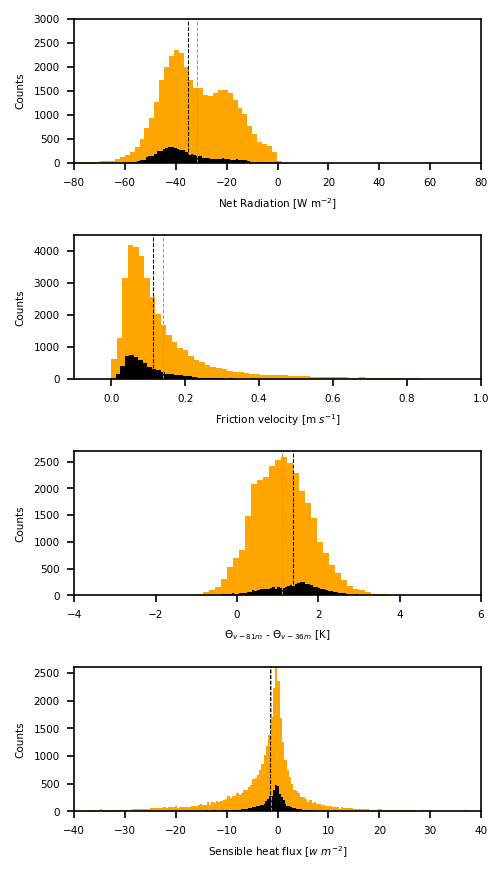

In [60]:
# be aware that I havent checked here if there is missing data 
fig  = plt.figure(figsize=(3.5,7),dpi=150)
grid = plt.GridSpec(4,1,wspace=0.2,hspace=0.5)

row1 = fig.add_subplot(grid[0,0])
data = df_full_n[['Hour','GradFlag','NetRad']]
sns.distplot(data['NetRad'].loc[data['GradFlag']==False].dropna(),bins=500,ax=row1,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "orange"})
sns.distplot(data['NetRad'].loc[data['GradFlag']==True].dropna(),bins=500,ax=row1,hist=True,kde=False,
             hist_kws={"alpha": 1, "color": "k"})
row1.vlines(data['NetRad'].loc[data['GradFlag']==True].dropna().mean(),0,3000,linestyles='--',linewidth=0.5,colors='k')
row1.vlines(data['NetRad'].loc[data['GradFlag']==False].dropna().mean(),0,3000,linestyles='--',linewidth=0.5,color='darkorange')
row1.set_xlim(-80,80)
row1.set_ylim(0,3000)
row1.set_ylabel('Counts')
row1.set_xlabel('Net Radiation [W m$^{-2}$]')
print('NetRad',scipy.stats.ks_2samp(data['NetRad'].loc[data['GradFlag']==False].dropna().values,
                           data['NetRad'].loc[data['GradFlag']==True].dropna().values))

row2 = fig.add_subplot(grid[1,0])
data = df_full_n[['Hour','GradFlag','U-star[m/s]']]
sns.distplot(data['U-star[m/s]'].loc[data['GradFlag']==False].dropna(),bins=100,ax=row2,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "orange"})
sns.distplot(data['U-star[m/s]'].loc[data['GradFlag']==True].dropna(),bins=100,ax=row2,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "k"})
row2.vlines(data['U-star[m/s]'].loc[data['GradFlag']==True].dropna().mean(),0,5000,linestyles='--',linewidth=0.5,color='k')
row2.vlines(data['U-star[m/s]'].loc[data['GradFlag']==False].dropna().mean(),0,5000,linestyles='--',linewidth=0.5,colors='darkorange')
row2.set_xlim(-0.1,1)
row2.set_ylim(0,4500)
row2.set_ylabel('Counts')
row2.set_xlabel('Friction velocity [m $s^{-1}$]')
print('U*',scipy.stats.ks_2samp(data['U-star[m/s]'].loc[data['GradFlag']==False].dropna().values,
                           data['U-star[m/s]'].loc[data['GradFlag']==True].dropna().values))

row3 = fig.add_subplot(grid[2,0])
data = df_full_n[['Hour','GradFlag','PotVirt_81m','PotVirt_36m']]
data = data.assign(PotGradAbove = data['PotVirt_81m'] - data['PotVirt_36m'])
sns.distplot(data['PotGradAbove'].loc[data['GradFlag']==False].dropna(),bins=100,ax=row3,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "orange"})
sns.distplot(data['PotGradAbove'].loc[data['GradFlag']==True].dropna(),bins=100,ax=row3,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "k"})
row3.vlines(data['PotGradAbove'].loc[data['GradFlag']==True].dropna().mean(),0,2700,linestyles='--',linewidth=0.5,color='k')
row3.vlines(data['PotGradAbove'].loc[data['GradFlag']==False].dropna().mean(),0,2700,linestyles='--',linewidth=0.5,color='darkorange')
row3.set_xlim(-4,6)
row3.set_ylim(0,2700)
row3.set_ylabel('Counts')
row3.set_xlabel('$\Theta_{v-81m}$ - $\Theta_{v-36m}$ [K]')
print('Theta',scipy.stats.ks_2samp(data['PotGradAbove'].loc[data['GradFlag']==False].dropna().values,
                           data['PotGradAbove'].loc[data['GradFlag']==True].dropna().values))


row4 = fig.add_subplot(grid[3,0])
data = df_full_n[['Hour','GradFlag','FluxTsonic[Watt/m2]']]
sns.distplot(data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==False].dropna(),bins=1000,ax=row4,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "orange"})
sns.distplot(data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==True].dropna(),bins=1000,ax=row4,hist=True,kde=False,
            hist_kws={"alpha": 1, "color": "k"})
row4.vlines(data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==True].dropna().mean(),0,2700,linestyles='--',linewidth=0.5,color='k')
row4.vlines(data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==False].dropna().mean(),0,2700,linestyles='--',linewidth=0.5,color='darkorange')
row4.set_xlim(-40,40)
row4.set_ylim(0,2600)
row4.set_ylabel('Counts')
row4.set_xlabel('Sensible heat flux [$w$ $m^{-2}$]')
print('H',scipy.stats.ks_2samp(data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==False].dropna().values,
                           data['FluxTsonic[Watt/m2]'].loc[data['GradFlag']==True].dropna().values))
plt.show()

### Analysis of Stability above canopy using Bulk Richardson Number
- Analysis not included in paper
- I think the 1/L analysis is more reliable at 1 min resolution
- Ri <= 0.25 weakly stable
- Ri > 0.25 very stable

#### Checking z/L and Bulk Richardson number , comment from referee 2

In [70]:
# selecting data
data        = df_full_n[['Hour','grad','GradFlag','PotVirt_81m','PotVirt_36m','grad_quant_mid','Ritop','FluxTsonic[Watt/m2]','Mean_Windsp[m/s]','Z-over-L']]
data        = data.assign(PotGradAbove   = data['PotVirt_81m'] - data['PotVirt_36m'])
data['Z-over-L'] = data['Z-over-L']*(1/61) # transforming z-over-L into 1/L
# setting ranges for z_over_l and ritop
IQR_z_l     = data['Z-over-L'].describe()[6] - data['Z-over-L'].describe()[4]
loval_z_l   = data['Z-over-L'].describe()[4] - 1.5 * IQR_z_l
hival_z_l   = data['Z-over-L'].describe()[6] + 1.5 * IQR_z_l

IQR_ritop   = data['Ritop'].describe()[6] - data['Ritop'].describe()[4]
loval_ritop = data['Ritop'].describe()[4] - 1.5 * IQR_ritop
hival_ritop = data['Ritop'].describe()[6] + 1.5 * IQR_ritop

data        = data.assign(Ritop_range    = data['Ritop'].between(loval_ritop, hival_ritop, inclusive=True))
data        = data.assign(z_over_l_range = data['Z-over-L'].between(loval_z_l, hival_z_l, inclusive=True))

bins        = pd.IntervalIndex.from_tuples([(loval_ritop, 0.25), (0.25, hival_ritop)])
data        = data.assign(Ritop_int      = pd.cut(data[data['Ritop_range']==True]['Ritop'],bins=bins))
bins        = pd.IntervalIndex.from_tuples([(-0.1,-0.01),(-0.01,0.01),(0.01,0.1),(0.1,hival_z_l)])
data        = data.assign(z_over_l_int   = pd.cut(data[data['z_over_l_range']==True]['Z-over-L'],bins=bins))

data        = data.assign(Ritop_int_mid = data['Ritop_int'].apply(mid))
data        = data.assign(Ritop_int_mid = data['z_over_l_int'].apply(mid))

data        = data.assign(StabilityFlag = np.where(data['Ritop']>0.25, 'Stable', 'Weakly stable'))

In [62]:
data[data['Ritop_range']==True].groupby(by='Ritop_int')['GradFlag'].count()

Ritop_int
(-1.4858753304918575, 0.25]    4243
(0.25, 3.1096968107372462]     9084
Name: GradFlag, dtype: int64

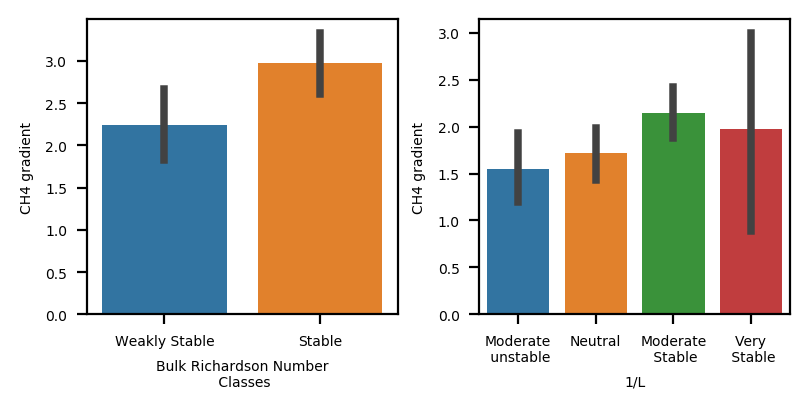

In [63]:
fig,(row1,ax1)    = plt.subplots(1,2,figsize=(4,2),dpi=200)

#sns.boxplot(x='Ritop_int',y='grad',data=data[data['Ritop_range']==True],showfliers=False,ax=row1)
#sns.boxplot(x='z_over_l_int',y='grad',data=data[data['z_over_l_range']==True],showfliers=False,ax=ax1)
sns.barplot(x='Ritop_int',y='grad',data=data[data['Ritop_range']==True],ax=row1)
sns.barplot(x='z_over_l_int',y='grad',data=data[data['z_over_l_range']==True],ax=ax1)

row1.set_xticklabels(['Weakly Stable','Stable'],fontsize=5)
row1.set_xlabel('Bulk Richardson Number\n Classes')
row1.set_ylabel('CH4 gradient')

ax1.set_xticklabels(['Moderate\n unstable','Neutral','Moderate\n Stable','Very\n Stable'],fontsize=5)
ax1.set_ylabel('CH4 gradient')
ax1.set_xlabel('1/L')
mpl.rcParams['font.size'] = 5
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

#fig.savefig('../Rebuttal/z-L_bulkRi_boxplot_nighttime.png',dpi=300)
fig.savefig('../Rebuttal/z-L_bulkRi_barplot_nighttime.png',dpi=300)

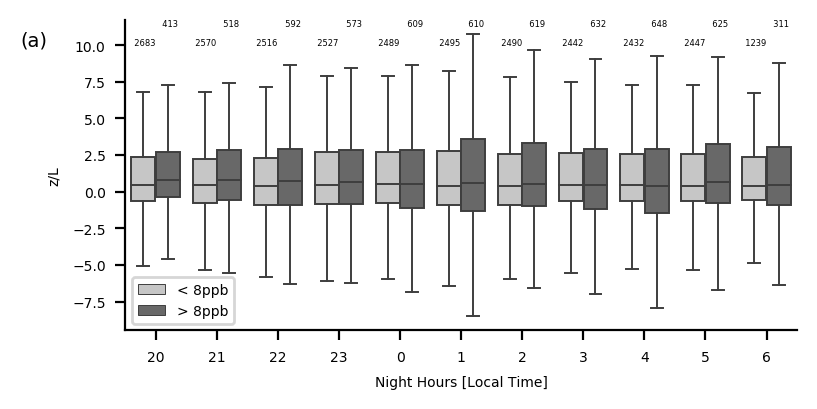

In [64]:
# Plot settings
line_width  = 0.7
marker_size = 2
font_size   = 6
fig,row1    = plt.subplots(1,1,figsize=(4,2),dpi=200)

data     = df_full_n[['Hour','GradFlag','grad','Z-over-L']].dropna()
df_true  = data[data["GradFlag"]==True].groupby('Hour').count()
df_false = data[data["GradFlag"]==False].groupby('Hour').count()
nobsT    = df_true['Z-over-L']
nobsF    = df_false['Z-over-L']
nobs1    = ["  " + str(i) for i in nobsT.values]
new_nobs1 = nobs1[7:] + nobs1[0:7]
#nobs2    = ["n:" + str(i) + " " for i in nobsF.values]
nobs2    = ["  " + str(i) + " " for i in nobsF.values]
new_nobs2 = nobs2[7:] + nobs2[0:7]

meansTrue  = [str(i) for i in data[data['GradFlag']==True].groupby('Hour').mean()['Z-over-L'].values]
meansFalse = [str(i) for i in data[data['GradFlag']==False].groupby('Hour').mean()['Z-over-L'].values]
meansTrue  = meansTrue[7:] + meansTrue[0:7]
meansFalse = meansFalse[7:] + meansFalse[0:7]
meansTrue  = [float(i) for i in meansTrue]
meansFalse = [float(i) for i in meansFalse]

sns.boxplot(x='Hour',y='Z-over-L',hue='GradFlag',data=data,order=[20,21,22,23,0,1,2,3,4,5,6],palette=sns.color_palette(palette="Greys",n_colors=2),showfliers=False,ax=row1,showmeans=False,linewidth=line_width)
#sns.violinplot(x='Hour',y='Ritop',hue='GradFlag',data=data,order=[20,21,22,23,0,1,2,3,4,5,6],palette=sns.color_palette(palette="Greys",n_colors=2),ax=row1,linewidth=line_width)
row1.set_xlabel('Night Hours [Local Time]')
row1.set_ylabel('z/L')
#row1.set_xticklabels(['','','','','','','','','','',''])
row1.get_legend().remove()
sns.despine()
row1.text(-2, 10, '(a)', horizontalalignment='center', size=7, color='k')    
for i,j in enumerate(new_nobs1):
    row1.text(i+0.2, 11.3, j, horizontalalignment='center', size=3, color='k')
    row1.text(i-0.2, 10, new_nobs2[i], horizontalalignment='center', size=3, color='k')
#row1.plot([0.25,1.25,2.25,3.25,4.25,5.25,6.25,7.25,8.25,9.25,10.25],meansTrue,linewidth=0,marker='v',markersize=1,color='lightgreen')
#row1.plot([-0.25,0.85,1.85,2.85,3.85,4.85,5.85,6.85,7.85,8.85,9.85],meansFalse,linewidth=0,marker='v',markersize=1,color='lightgreen')
handles, _ = row1.get_legend_handles_labels()
row1.legend(handles,["< 8ppb", "> 8ppb"],loc='lower left',fontsize=5)
plt.tight_layout()
plt.show()
fig.savefig('../Rebuttal/z-L_boxplot_nighttime_above_below_8ppb.png',dpi=300)

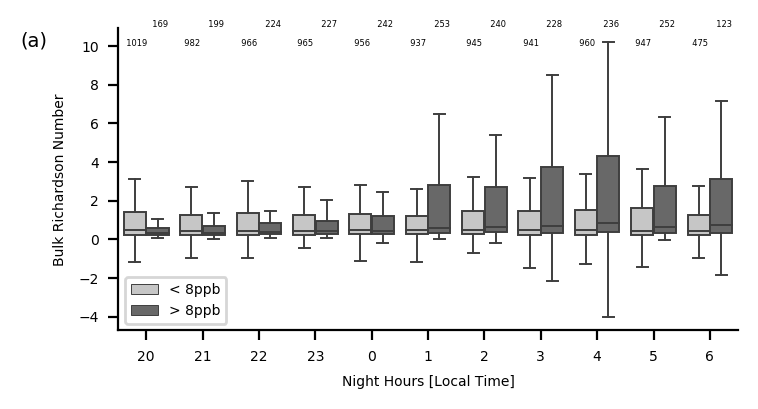

In [68]:
# Plot settings
# Remember to re-run the selecting data cell. Two above
line_width  = 0.7
marker_size = 2
font_size   = 6
fig      = plt.figure(figsize=(4,2),dpi=200)
grid     = plt.GridSpec(1,1,wspace=0.6,hspace=0.5)

row1     = fig.add_subplot(grid[0,0])
data     = data[['Hour','GradFlag','grad','Ritop']].dropna()
df_true  = data[data["GradFlag"]==True].groupby('Hour').count()
df_false = data[data["GradFlag"]==False].groupby('Hour').count()
nobsT    = df_true['Ritop']
nobsF    = df_false['Ritop']
nobs1    = ["  " + str(i) for i in nobsT.values]
new_nobs1 = nobs1[7:] + nobs1[0:7]
#nobs2    = ["n:" + str(i) + " " for i in nobsF.values]
nobs2    = ["  " + str(i) + " " for i in nobsF.values]
new_nobs2 = nobs2[7:] + nobs2[0:7]

meansTrue  = [str(i) for i in data[data['GradFlag']==True].groupby('Hour').mean()['Ritop'].values]
meansFalse = [str(i) for i in data[data['GradFlag']==False].groupby('Hour').mean()['Ritop'].values]
meansTrue  = meansTrue[7:] + meansTrue[0:7]
meansFalse = meansFalse[7:] + meansFalse[0:7]
meansTrue  = [float(i) for i in meansTrue]
meansFalse = [float(i) for i in meansFalse]

sns.boxplot(x='Hour',y='Ritop',hue='GradFlag',data=data,order=[20,21,22,23,0,1,2,3,4,5,6],palette=sns.color_palette(palette="Greys",n_colors=2),showfliers=False,ax=row1,showmeans=False,linewidth=line_width)
#sns.violinplot(x='Hour',y='Ritop',hue='GradFlag',data=data,order=[20,21,22,23,0,1,2,3,4,5,6],palette=sns.color_palette(palette="Greys",n_colors=2),ax=row1,linewidth=line_width)
row1.set_xlabel('Night Hours [Local Time]')
row1.set_ylabel('Bulk Richardson Number')
#row1.set_xticklabels(['','','','','','','','','','',''])
row1.get_legend().remove()
sns.despine()
row1.text(-2, 10, '(a)', horizontalalignment='center', size=7, color='k')    
for i,j in enumerate(new_nobs1):
    row1.text(i+0.2, 11, j, horizontalalignment='center', size=3, color='k')
    row1.text(i-0.2, 10, new_nobs2[i], horizontalalignment='center', size=3, color='k')
#row1.plot([0.25,1.25,2.25,3.25,4.25,5.25,6.25,7.25,8.25,9.25,10.25],meansTrue,linewidth=0,marker='v',markersize=1,color='lightgreen')
#row1.plot([-0.25,0.85,1.85,2.85,3.85,4.85,5.85,6.85,7.85,8.85,9.85],meansFalse,linewidth=0,marker='v',markersize=1,color='lightgreen')
handles, _ = row1.get_legend_handles_labels()
row1.legend(handles,["< 8ppb", "> 8ppb"],loc='lower left',fontsize=5)
plt.show()
fig.savefig('../Rebuttal/BulkRi_boxplot_nighttime_above_below_8ppb.png',dpi=300)

In [71]:
# Counting the amount of events at 30min, in which they happened under stable or weakly stable conditions
# This was not addded to paper
data[data['GradFlag']==True].groupby('StabilityFlag').count()['GradFlag']

StabilityFlag
Stable           1976
Weakly stable    4836
Name: GradFlag, dtype: int64

## Wind Speed Analysis
- Here I look at the distribution of the wind speed to have an idea of what are the most probable distances
- This information is used in Section 3.3.1, 80% of the wind speed for nighttime positive gradients is below 4 m s-1

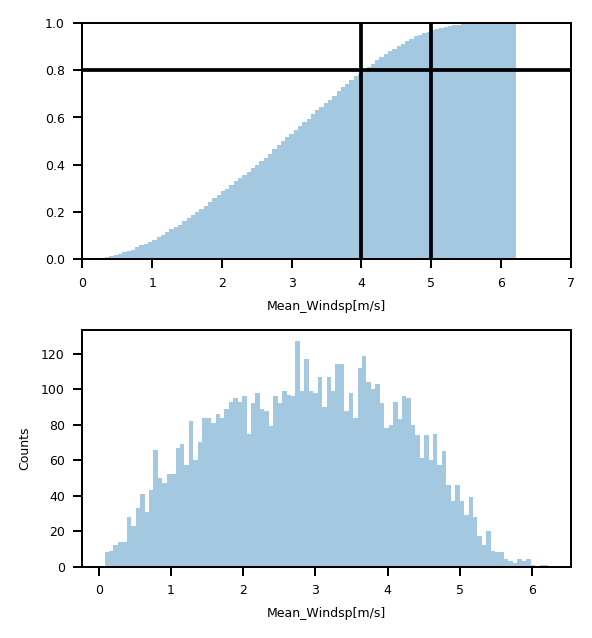

In [73]:
# Looking at the distribution of wind speed using the positive gradient flag
fig  = plt.figure(figsize=(3.5,4),dpi=180)
grid = plt.GridSpec(2,1,wspace=0.5,hspace=0.3)

ax1  = fig.add_subplot(grid[0, 0])
sns.distplot(df_full_n['Mean_Windsp[m/s]'].loc[df_full_n['GradFlag']==True].dropna(), bins=100, 
             hist_kws=dict(cumulative=True),kde_kws=dict(lw=0),ax=ax1) #hist_kws=dict(cumulative=True)

ax1.vlines(5,0,1)
ax1.vlines(4,0,1)
ax1.hlines(0.8,-2,15)
ax1.set_xlim(0,7)
ax1.set_ylim(0,1)

ax2  = fig.add_subplot(grid[1, 0])
sns.distplot(df_full_n['Mean_Windsp[m/s]'].loc[df_full_n['GradFlag']==True].dropna(),bins=100,ax=ax2,kde=False)
ax2.set_ylabel('Counts')
plt.show()

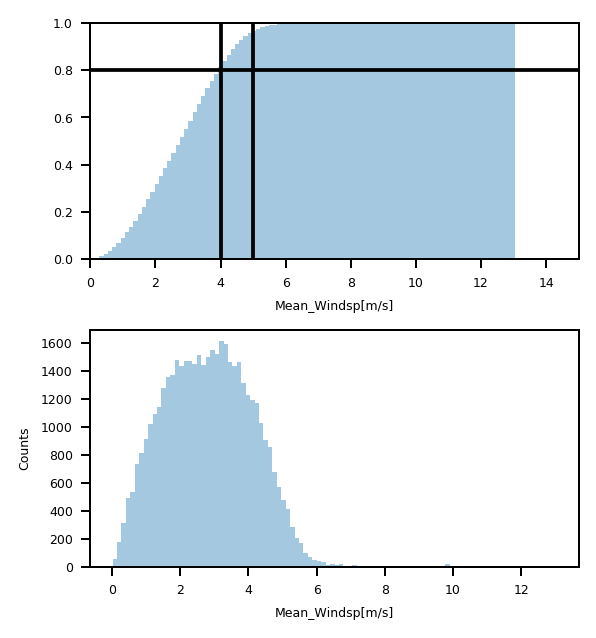

In [74]:
# All nighttime, no use of positive gradient flag
fig  = plt.figure(figsize=(3.5,4),dpi=180)
grid = plt.GridSpec(2,1,wspace=0.5,hspace=0.3)

ax1  = fig.add_subplot(grid[0, 0])
sns.distplot(df_full_n['Mean_Windsp[m/s]'].dropna(),bins=100,
             hist_kws=dict(cumulative=True),kde_kws=dict(lw=0),ax=ax1)

ax1.vlines(5,0,1)
ax1.vlines(4,0,1)
ax1.hlines(0.8,-2,17)
ax1.set_xlim(0,15)
ax1.set_ylim(0,1)

ax2  = fig.add_subplot(grid[1, 0])
sns.distplot(df_full_n['Mean_Windsp[m/s]'].dropna(),ax=ax2,bins=100,kde=False)
ax2.set_ylabel('Counts')
plt.show()

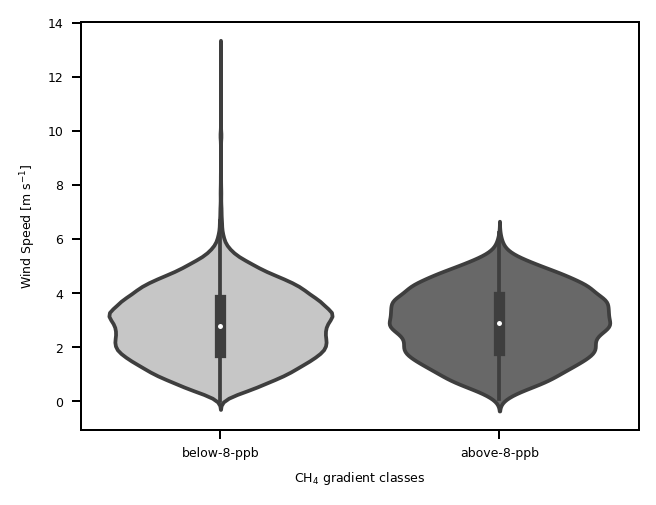

In [75]:
fig,ax1  = plt.subplots(1,1,figsize=(4,3),dpi=180)

#sns.distplot(df_full_n['Mean_Windsp[m/s]'].loc[df_full_n['GradFlag']==True].dropna(), bins=10, kde=False, norm_hist=True,ax=ax1) #hist_kws=dict(cumulative=True)
#sns.distplot(df_full_n['Mean_Windsp[m/s]'].loc[df_full_n['GradFlag']==False].dropna(), bins=10, kde=False,norm_hist=True,ax=ax1) #hist_kws=dict(cumulative=True)
sns.violinplot(x='GradFlag',y=df_full_n['Mean_Windsp[m/s]'], data=df_full_n, ax=ax1,palette=sns.color_palette(palette="Greys",n_colors=2)) #hist_kws=dict(cumulative=True)
#sns.boxplot(df_full_n['Mean_Windsp[m/s]'].loc[df_full_n['GradFlag']==False].dropna(),showfliers=False, ax=ax1) #hist_kws=dict(cumulative=True)
ax1.set_xticklabels(['below-8-ppb','above-8-ppb'])

plt.ylabel('Wind Speed [m s$^{-1}$]')
plt.xlabel('CH$_4$ gradient classes')

plt.show()

### The following supports indirectly the rejection of the Amazon river as a source, because 
- Almost 71 % of events happen at wind speeds between 1-4 m s-1

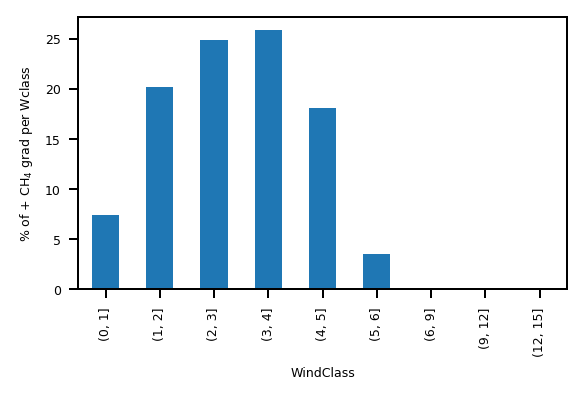

In [76]:
fig  = plt.figure(figsize=(3.5,2),dpi=180)
bins             = [np.arange(0,6,1),np.arange(6,18,3)]
bins             = np.concatenate(bins).ravel()
df_full_n        = df_full_n.assign(WindClass = pd.cut(df_full_n['Mean_Windsp[m/s]'],bins,right=True))
wind_c_group     = df_full_n[['WindClass','GradFlag']].dropna().groupby('WindClass').sum()
wind_c_group     = wind_c_group.assign(Per_event_Wclass = wind_c_group.GradFlag/wind_c_group.GradFlag.sum() * 100)
wind_c_group['Per_event_Wclass'].plot(kind='bar')
plt.ylabel('% of + CH$_4$ grad per Wclass')
plt.show()

## Checking systematic differences in wind direction suggested by Referee #2

In [77]:
df_full_n = df_full_n.loc['2013-06-01':'2018-11-30']

147.50224500427092 212.27986936696433 -64.77762436269342 81-19 mean range
147.6533784448756 195.70288314898903 -48.04950470411342 81-26 mean range
143.6251168714838 169.73016021578655 -26.105043344302743 81-42 mean range
136.0402697179403 201.8884331260815 -65.8481634081412 81-19 mean range
136.01641505836625 182.38862113281652 -46.372206074450276 81-26 mean range
125.27875126705726 151.17753157268913 -25.898780305631874 81-42 mean range
141.76041483338585 200.79782906028473 -59.037414226898875 81-19 mean range
141.76041483338585 183.36401753395373 -41.603602700567876 81-26 mean range
136.7603549944775 145.34175616478436 -8.581401170306862 81-42 mean range


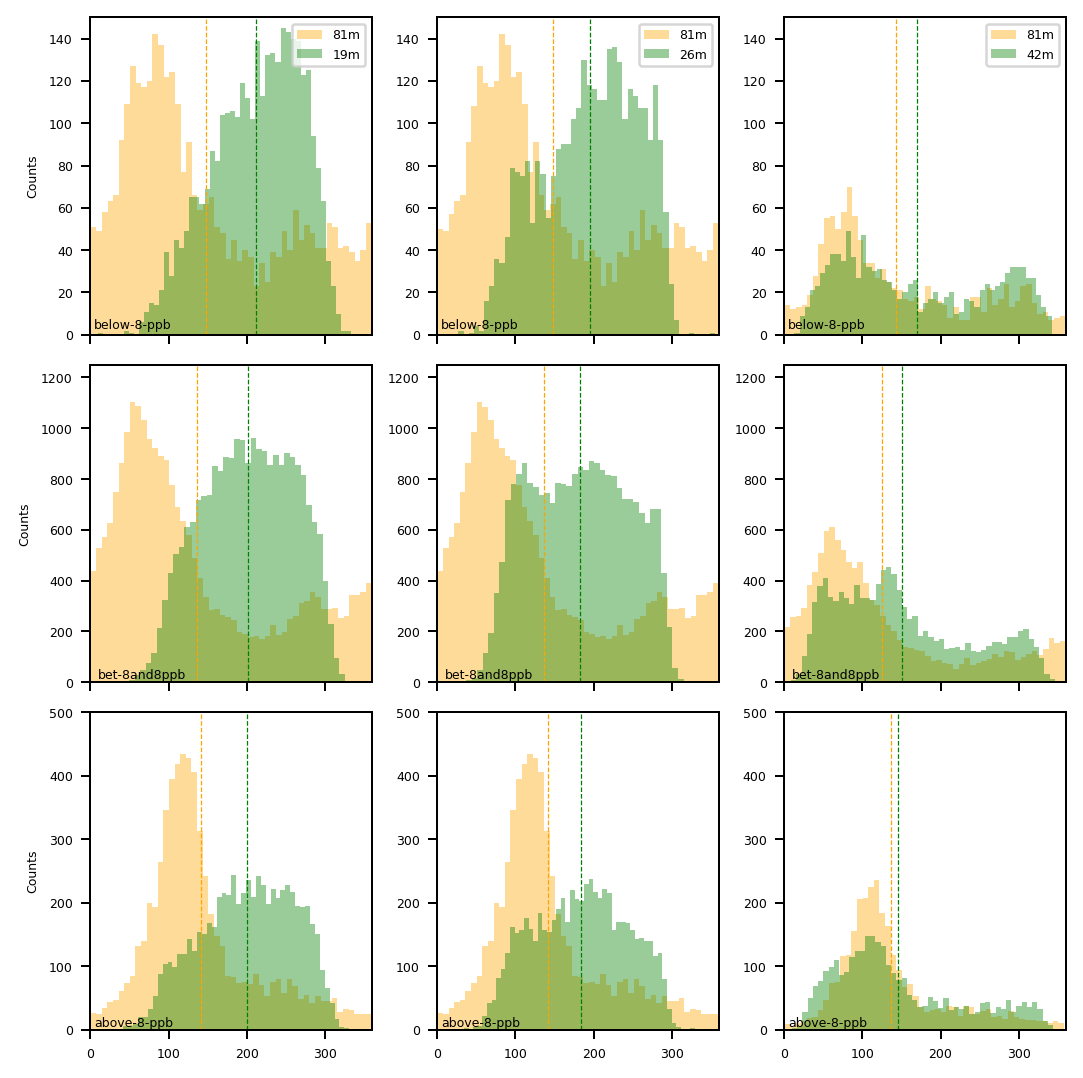

In [78]:
################ Checking systematic wind directions differences for below -8ppb

df_full_n = df_full_n.assign(wdir_flag42 = df_full_n['WDir_42m'].isnull() )
df_full_n = df_full_n.assign(wdir_flag19 = df_full_n['WDir_19m'].isnull() )
df_full_n = df_full_n.assign(wdir_flag26 = df_full_n['WDir_26m'].isnull() )
df_full_n = df_full_n.assign(above8ppb = df_full_n['grad']>=8)
df_full_n = df_full_n.assign(below8ppb = df_full_n['grad']<=-8)
df_full_n = df_full_n.assign(betweenFlag = ((df_full_n['grad']>-8) & (df_full_n['grad']<8)))

wind_dir79m_42m = df_full_n.loc[(df_full_n['below8ppb']==True) & (df_full_n['wdir_flag42']==False),['Wind-Direc-corrg[deg]','WDir_42m']]
wind_dir79m_26m = df_full_n.loc[(df_full_n['below8ppb']==True) & (df_full_n['wdir_flag26']==False),['Wind-Direc-corrg[deg]','WDir_26m']]
wind_dir79m_19m = df_full_n.loc[(df_full_n['below8ppb']==True) & (df_full_n['wdir_flag19']==False),['Wind-Direc-corrg[deg]','WDir_19m']]

fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(6,6),dpi=180,sharex=True)#,constrained_layout=True)

sns.distplot(wind_dir79m_19m['Wind-Direc-corrg[deg]'],bins=50,ax=ax1,kde=False,color='orange',label='81m')
sns.distplot(wind_dir79m_19m['WDir_19m'],bins=50,ax=ax1,kde=False,color='green',label='19m')
ax1.set_xlabel('')
ax1.vlines(wind_dir79m_19m['Wind-Direc-corrg[deg]'].mean(),0,2000,linestyles='--',linewidth=0.5,color='orange')
ax1.vlines(wind_dir79m_19m['WDir_19m'].mean(),0,2000,linestyles='--',linewidth=0.5,color='green')
ax1.set_ylabel('Counts')
ax1.set_ylim(0,150)
ax1.set_xlim(0,360)
ax1.legend(loc='upper right')
ax1.text(5,3,'below-8-ppb')

sns.distplot(wind_dir79m_26m['Wind-Direc-corrg[deg]'],ax=ax2,bins=50,kde=False,color='orange',label='81m')
sns.distplot(wind_dir79m_26m['WDir_26m'],ax=ax2,bins=50,kde=False,color='green',label='26m')
#ax2.set_ylabel('Counts')
ax2.set_xlabel('')
ax2.set_ylim(0,150)
ax2.set_xlim(0,360)
ax2.vlines(wind_dir79m_26m['Wind-Direc-corrg[deg]'].mean(),0,2000,linestyles='--',linewidth=0.5,color='orange')
ax2.vlines(wind_dir79m_26m['WDir_26m'].mean(),0,2000,linestyles='--',linewidth=0.5,color='green')
ax2.legend()
ax2.text(5,3,'below-8-ppb')

sns.distplot(wind_dir79m_42m['Wind-Direc-corrg[deg]'],ax=ax3,bins=50,kde=False,color='orange',label='81m')
sns.distplot(wind_dir79m_42m['WDir_42m'],ax=ax3,bins=50,kde=False,color='green',label='42m')
#ax3.set_ylabel('Counts')
ax3.set_xlabel('')
ax3.set_ylim(0,150)
ax3.set_xlim(0,360)
ax3.vlines(wind_dir79m_42m['Wind-Direc-corrg[deg]'].mean(),0,2000,linestyles='--',linewidth=0.5,color='orange')
ax3.vlines(wind_dir79m_42m['WDir_42m'].mean(),0,2000,linestyles='--',linewidth=0.5,color='green')
ax3.legend()
ax3.text(5,3,'below-8-ppb')

print(wind_dir79m_19m['Wind-Direc-corrg[deg]'].mean(),wind_dir79m_19m['WDir_19m'].mean(),wind_dir79m_19m['Wind-Direc-corrg[deg]'].mean()-wind_dir79m_19m['WDir_19m'].mean(),'81-19 mean range')
print(wind_dir79m_26m['Wind-Direc-corrg[deg]'].mean(),wind_dir79m_26m['WDir_26m'].mean(),wind_dir79m_26m['Wind-Direc-corrg[deg]'].mean()-wind_dir79m_26m['WDir_26m'].mean(),'81-26 mean range')
print(wind_dir79m_42m['Wind-Direc-corrg[deg]'].mean(),wind_dir79m_42m['WDir_42m'].mean(),wind_dir79m_42m['Wind-Direc-corrg[deg]'].mean()-wind_dir79m_42m['WDir_42m'].mean(),'81-42 mean range')

############################################################################################
############################################################################################
################ Checking systematic wind directions differences for between -8ppb and 8 ppb
############################################################################################
############################################################################################

wind_dir79m_42m = df_full_n.loc[(df_full_n['betweenFlag']==True) & (df_full_n['wdir_flag42']==False),['Wind-Direc-corrg[deg]','WDir_42m']]
wind_dir79m_26m = df_full_n.loc[(df_full_n['betweenFlag']==True) & (df_full_n['wdir_flag26']==False),['Wind-Direc-corrg[deg]','WDir_26m']]
wind_dir79m_19m = df_full_n.loc[(df_full_n['betweenFlag']==True) & (df_full_n['wdir_flag19']==False),['Wind-Direc-corrg[deg]','WDir_19m']]

sns.distplot(wind_dir79m_19m['Wind-Direc-corrg[deg]'],bins=50,ax=ax4,kde=False,color='orange',label='81m')
sns.distplot(wind_dir79m_19m['WDir_19m'],bins=50,ax=ax4,kde=False,color='green',label='19m')
ax4.set_xlabel('')
ax4.vlines(wind_dir79m_19m['Wind-Direc-corrg[deg]'].mean(),0,2000,linestyles='--',linewidth=0.5,color='orange')
ax4.vlines(wind_dir79m_19m['WDir_19m'].mean(),0,2000,linestyles='--',linewidth=0.5,color='green')
ax4.set_ylabel('Counts')
ax4.set_ylim(0,1250)
ax4.set_xlim(0,360)
ax4.text(10,15,'bet-8and8ppb')

sns.distplot(wind_dir79m_26m['Wind-Direc-corrg[deg]'],ax=ax5,bins=50,kde=False,color='orange',label='81m')
sns.distplot(wind_dir79m_26m['WDir_26m'],ax=ax5,bins=50,kde=False,color='green',label='26m')
#ax2.set_ylabel('Counts')
ax5.set_xlabel('')
ax5.set_ylim(0,1250)
ax5.set_xlim(0,360)
ax5.vlines(wind_dir79m_26m['Wind-Direc-corrg[deg]'].mean(),0,2000,linestyles='--',linewidth=0.5,color='orange')
ax5.vlines(wind_dir79m_26m['WDir_26m'].mean(),0,2000,linestyles='--',linewidth=0.5,color='green')
#ax5.legend()
ax5.text(10,15,'bet-8and8ppb')

sns.distplot(wind_dir79m_42m['Wind-Direc-corrg[deg]'],ax=ax6,bins=50,kde=False,color='orange',label='81m')
sns.distplot(wind_dir79m_42m['WDir_42m'],ax=ax6,bins=50,kde=False,color='green',label='42m')
#ax3.set_ylabel('Counts')
ax6.set_xlabel('')
ax6.set_ylim(0,1250)
ax6.set_xlim(0,360)
ax6.vlines(wind_dir79m_42m['Wind-Direc-corrg[deg]'].mean(),0,2000,linestyles='--',linewidth=0.5,color='orange')
ax6.vlines(wind_dir79m_42m['WDir_42m'].mean(),0,2000,linestyles='--',linewidth=0.5,color='green')
#ax6.legend()
ax6.text(10,15,'bet-8and8ppb')

print(wind_dir79m_19m['Wind-Direc-corrg[deg]'].mean(),wind_dir79m_19m['WDir_19m'].mean(),wind_dir79m_19m['Wind-Direc-corrg[deg]'].mean()-wind_dir79m_19m['WDir_19m'].mean(),'81-19 mean range')
print(wind_dir79m_26m['Wind-Direc-corrg[deg]'].mean(),wind_dir79m_26m['WDir_26m'].mean(),wind_dir79m_26m['Wind-Direc-corrg[deg]'].mean()-wind_dir79m_26m['WDir_26m'].mean(),'81-26 mean range')
print(wind_dir79m_42m['Wind-Direc-corrg[deg]'].mean(),wind_dir79m_42m['WDir_42m'].mean(),wind_dir79m_42m['Wind-Direc-corrg[deg]'].mean()-wind_dir79m_42m['WDir_42m'].mean(),'81-42 mean range')

############################################################################################
############################################################################################
################ Checking systematic wind directions differences for above 8 ppb
############################################################################################
############################################################################################

wind_dir79m_42m = df_full_n.loc[(df_full_n['above8ppb']==True) & (df_full_n['wdir_flag42']==False),['Wind-Direc-corrg[deg]','WDir_42m']]
wind_dir79m_26m = df_full_n.loc[(df_full_n['above8ppb']==True) & (df_full_n['wdir_flag26']==False),['Wind-Direc-corrg[deg]','WDir_26m']]
wind_dir79m_19m = df_full_n.loc[(df_full_n['above8ppb']==True) & (df_full_n['wdir_flag19']==False),['Wind-Direc-corrg[deg]','WDir_19m']]

sns.distplot(wind_dir79m_19m['Wind-Direc-corrg[deg]'],bins=50,ax=ax7,kde=False,color='orange',label='81m')
sns.distplot(wind_dir79m_19m['WDir_19m'],bins=50,ax=ax7,kde=False,color='green',label='19m')
ax7.set_xlabel('')
ax7.vlines(wind_dir79m_19m['Wind-Direc-corrg[deg]'].mean(),0,2000,linestyles='--',linewidth=0.5,color='orange')
ax7.vlines(wind_dir79m_19m['WDir_19m'].mean(),0,2000,linestyles='--',linewidth=0.5,color='green')
ax7.set_ylabel('Counts')
ax7.set_ylim(0,500)
ax7.set_xlim(0,360)
ax7.text(5,5,'above-8-ppb')
#ax7.legend()

sns.distplot(wind_dir79m_26m['Wind-Direc-corrg[deg]'],ax=ax8,bins=50,kde=False,color='orange',label='81m')
sns.distplot(wind_dir79m_26m['WDir_26m'],ax=ax8,bins=50,kde=False,color='green',label='26m')
#ax2.set_ylabel('Counts')
ax8.set_xlabel('')
ax8.set_ylim(0,500)
ax8.set_xlim(0,360)
ax8.vlines(wind_dir79m_26m['Wind-Direc-corrg[deg]'].mean(),0,2000,linestyles='--',linewidth=0.5,color='orange')
ax8.vlines(wind_dir79m_26m['WDir_26m'].mean(),0,2000,linestyles='--',linewidth=0.5,color='green')
#ax8.legend()
ax8.text(5,5,'above-8-ppb')

sns.distplot(wind_dir79m_42m['Wind-Direc-corrg[deg]'],ax=ax9,bins=50,kde=False,color='orange',label='81m')
sns.distplot(wind_dir79m_42m['WDir_42m'],ax=ax9,bins=50,kde=False,color='green',label='42m')
#ax3.set_ylabel('Counts')
ax9.set_xlabel('')
ax9.set_ylim(0,500)
ax9.set_xlim(0,360)
ax9.vlines(wind_dir79m_42m['Wind-Direc-corrg[deg]'].mean(),0,2000,linestyles='--',linewidth=0.5,color='orange')
ax9.vlines(wind_dir79m_42m['WDir_42m'].mean(),0,2000,linestyles='--',linewidth=0.5,color='green')
#ax9.legend()
ax9.text(5,5,'above-8-ppb')

print(wind_dir79m_19m['Wind-Direc-corrg[deg]'].mean(),wind_dir79m_19m['WDir_19m'].mean(),wind_dir79m_19m['Wind-Direc-corrg[deg]'].mean()-wind_dir79m_19m['WDir_19m'].mean(),'81-19 mean range')
print(wind_dir79m_26m['Wind-Direc-corrg[deg]'].mean(),wind_dir79m_26m['WDir_26m'].mean(),wind_dir79m_26m['Wind-Direc-corrg[deg]'].mean()-wind_dir79m_26m['WDir_26m'].mean(),'81-26 mean range')
print(wind_dir79m_42m['Wind-Direc-corrg[deg]'].mean(),wind_dir79m_42m['WDir_42m'].mean(),wind_dir79m_42m['Wind-Direc-corrg[deg]'].mean()-wind_dir79m_42m['WDir_42m'].mean(),'81-42 mean range')

mpl.rcParams['font.size'] = 6
plt.tight_layout()
plt.show()
fig.savefig('../Rebuttal/Wdir_diff_81m_26m_19m_42m_classes.png',dpi=300)

## Checking coherent response of CO2 and CH4, comment by Referee #2

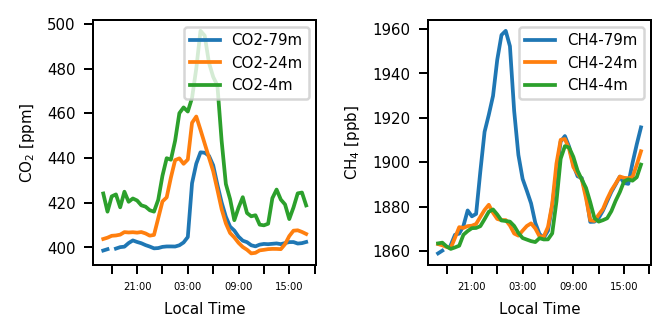

In [80]:
fig,(ax1,ax2)  = plt.subplots(1,2,figsize=(4,2),dpi=180)#,constrained_layout=True)

s = '2015-08-19 20:00'
e = '2015-08-20 20:00'

df_full.loc[s:e,['CO2_avg_79','CO2_avg_24','CO2_avg_4']].plot(x_compat=True,ax=ax1)
df_full.loc[s:e,['CH4_79','CH4_24','CH4_4']].plot(x_compat=True,ax=ax2)

ax1.set_ylabel('CO$_2$ [ppm]')
ax2.set_ylabel('CH$_4$ [ppb]')

ax1.set_xticklabels([' ','21:00',' ','03:00',' ','09:00',' ','15:00',' '],fontsize=4,rotation=0,horizontalalignment='center')
ax2.set_xticklabels([' ','21:00',' ','03:00',' ','09:00',' ','15:00',' '],fontsize=4,rotation=0,horizontalalignment='center')

ax1.set_xlabel('Local Time')
ax2.set_xlabel('Local Time')

ax1.legend(['CO2-79m','CO2-24m','CO2-4m'])
ax2.legend(['CH4-79m','CH4-24m','CH4-4m'])
plt.subplots_adjust(wspace=0.5)
plt.show()
#fig.savefig('./Figures/Rebuttal_CO2_CH4_enhan_2015-08-19.png',dpi=300)